In [1]:
!pip install -q "flwr[simulation]" flwr-datasets

In [2]:
!pip install matplotlib

In [4]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset


def get_mnist_dataloaders(mnist_dataset, batch_size: int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader


# Download dataset
mnist = load_dataset("ylecun/mnist")

In [5]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [6]:
import random
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt



def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

will display images with idx: [18877, 14710, 30139, 43730, 26478, 53847, 37054, 41049, 5751, 11722, 18775, 51456, 11495, 52657, 51919, 10864, 7008, 13435, 13989, 12033, 40398, 9924, 45114, 51149, 23762, 87, 29432, 41547, 39388, 28554, 59160, 13015]


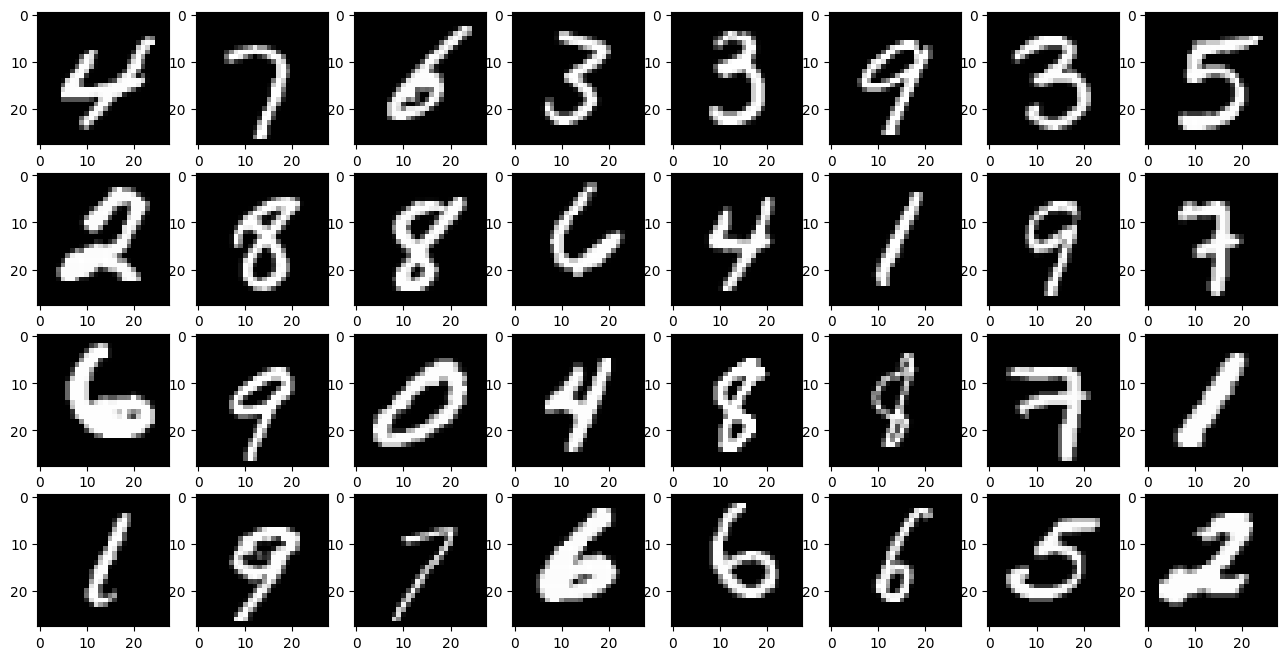

In [7]:
visualise_n_random_examples(mnist["train"], n=32)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def summary(self):
        print(self)

In [9]:
net = Net(num_classes=10)
net.summary()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
def train(net, trainloader, optimizer, device="cpu"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    for batch in trainloader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()


def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

def run_centralised(
    trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9
):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train for the specified number of epochs
    for e in range(epochs):
        print(f"Training epoch {e} ...")
        train(model, trainloader, optim, device)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(model, testloader, device)
    print(f"{loss = }")
    print(f"{accuracy = }")

In [10]:
# Construct dataloaders
trainloader, testloader = get_mnist_dataloaders(mnist, batch_size=32)

# Run the centralised training
run_centralised(trainloader, testloader, epochs=3, lr=0.01)

Training epoch 0 ...
Training epoch 1 ...
Training epoch 2 ...
loss = 12.597551989300882
accuracy = 0.987


In [16]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 1

partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)
# Let's partition the "train" split of the MNIST dataset
# The MNIST dataset will be downloaded if it hasn't been already
fds = FederatedDataset(dataset="ylecun/mnist", partitioners={"train": partitioner})

In [17]:

# We could load a single partition like this
partition_0 = fds.load_partition(0)
partition_0

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

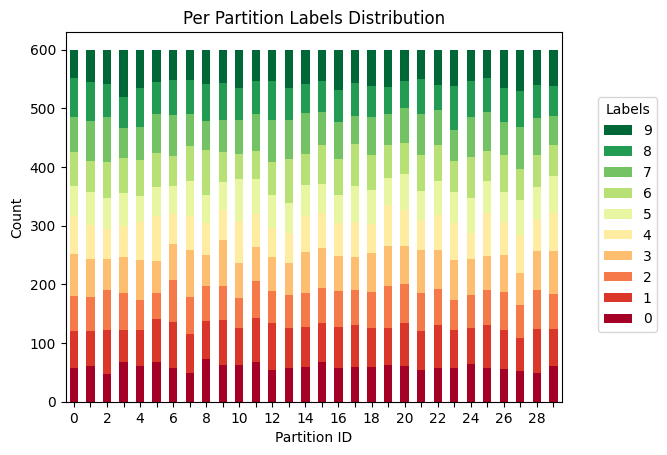

In [13]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

In [14]:

from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """서버에서 보낸 모델 파라미터로 클라이언트에서 로컬 학습 진행"""

        set_params(self.model, parameters)
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """서버에서 보낸 모델을 검증 데이터셋으로 평가"""

        set_params(self.model, parameters)
        loss, accuracy = test(self.model, self.valloader, self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}


# Two auxiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """서버에서 받은 파라미터를 클라이언트 모델에 적용"""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})

    print("\n📥 [클라이언트] 서버에서 받은 모델 파라미터 적용")

    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """클라이언트 모델의 학습된 파라미터를 서버로 전송"""

    params = [val.cpu().numpy() for _, val in model.state_dict().items()]

    print("\n [클라이언트] 학습된 파라미터 서버로 전송")

    return params  # 메시지 출력 후 반환 (순서 정리)






In [15]:
from flwr.common import Context
from flwr.client import ClientApp


def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    # Let's use the function defined earlier to construct the dataloaders
    # and apply the dataset transformations
    trainloader, testloader = get_mnist_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader).to_client()


# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

In [16]:
from typing import List
from flwr.common import Metrics


# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [17]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 10


def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=0.2,  # 20% clients sampled each round to do fit()
        fraction_evaluate=0.5,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

In [18]:

from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)



 [클라이언트] 학습된 파라미터 서버로 전송


(pid=1368) 2025-03-02 14:02:18.765478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1368) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1368) E0000 00:00:1740924138.807956    1368 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1368) E0000 00:00:1740924138.819139    1368 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1368) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1368) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1368) see the appropr

(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppAct

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(Clie

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppAct

INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=1368) 
(ClientAppActor pid=1368)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 142.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.584682989120483
INFO :      		round 2: 4.54961136341095
INFO :      		round 3: 4.471704416275024
INFO :      		round 4: 4.188448889255524
INFO :      		round 5: 2.8658896541595458
INFO :      		round 6: 1.4064647710323335
INFO :      		round 7: 1.117979222536087
INFO :      		round 8: 0.9242198902368546
INFO :      		round 9: 0.7561119508743286
INFO :      		round 10: 0.7019543229043483
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.1453333333333334),
INFO :      	              (2, 0.35600000000000004),
INFO :      	              (3, 0.5213333333333334),
INFO :      	              (4, 0.5213333333333334),
INFO :      	              (5, 0.6083333333333334),
INFO :      	              (6, 0.7983333333333333),
INFO :      	            

(ClientAppActor pid=1368) 
(ClientAppActor pid=1368) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용


cusomizing


In [19]:
from flwr.server.strategy import FedAvg
from flwr.common import Parameters
import json


class FedAvgCustom(FedAvg):
    def __init__(self, file_name: str, num_rounds: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_name = file_name
        self.num_rounds = num_rounds
        self.loss_list = []
        self.metrics_list = []

    def _make_plot(self):
        """Makes a plot with the results recorded"""
        round = list(range(1, len(self.loss_list) + 1))
        acc = [100.0 * metrics["accuracy"] for metrics in self.metrics_list]
        plt.plot(round, acc)
        plt.grid()
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Round")

    def evaluate(self, server_round: int, parameters: Parameters):
        """Evaluate model parameters using an evaluation function."""
        loss, metrics = super().evaluate(server_round, parameters)
        # Record results
        self.loss_list.append(loss)
        self.metrics_list.append(metrics)
        # If last round, save results and make a plot
        if server_round == self.num_rounds:
            # Save to CSV
            with open(f"{self.file_name}.json", "w") as f:
                json.dump({"loss": self.loss_list, "metrics": self.metrics_list}, f)
            # Generate plot
            self._make_plot()


def get_evaluate_fn(testloader):
    """Return a function that can be called to do global evaluation."""

    def evaluate_fn(server_round: int, parameters, config):
        """Evaluate global model on the whole test set."""

        model = Net(num_classes=10)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test (evaluate model as in centralised setting)
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn


In [20]:
from flwr.server import ServerApp, ServerConfig


def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvgCustom(
        file_name="results_fedavgcustom",
        num_rounds=num_rounds,
        fraction_fit=0.2,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.5,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
        evaluate_fn=get_evaluate_fn(
            testloader
        ),  # gloabl evaluation (here we can pass the same testset as used in centralised)
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters



 [클라이언트] 학습된 파라미터 서버로 전송


(pid=2315) 2025-03-02 14:04:44.130988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2315) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2315) E0000 00:00:1740924284.173643    2315 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2315) E0000 00:00:1740924284.186392    2315 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)
(ClientAppActor pid=2315) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to u

(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppAct

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(Clie

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(Clie

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(Clie

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 20 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송
(ClientAppActor pid=2315) 
(ClientAp

INFO :      aggregate_fit: received 20 results and 0 failures


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315)  [클라이언트] 학습된 파라미터 서버로 전송


INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)


(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용
(ClientAppActor 

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 170.95s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.580390567779541
INFO :      		round 2: 4.526230068206787
INFO :      		round 3: 4.381071858406067
INFO :      		round 4: 3.795446572303772
INFO :      		round 5: 1.925399774312973
INFO :      		round 6: 1.353553814291954
INFO :      		round 7: 0.9635354644060135
INFO :      		round 8: 0.8126998296380044
INFO :      		round 9: 0.7689244090020657
INFO :      		round 10: 0.6887245804071427
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.14266666666666666),
INFO :      	              (2, 0.23466666666666658),
INFO :      	              (3, 0.3789999999999999),
INFO :      	              (4, 0.5506666666666669),
INFO :      	              (5, 0.7489999999999998),
INFO :      	              (6, 0.8053333333333331),
INFO :      	           

(ClientAppActor pid=2315) 
(ClientAppActor pid=2315) 📥 [클라이언트] 서버에서 받은 모델 파라미터 적용


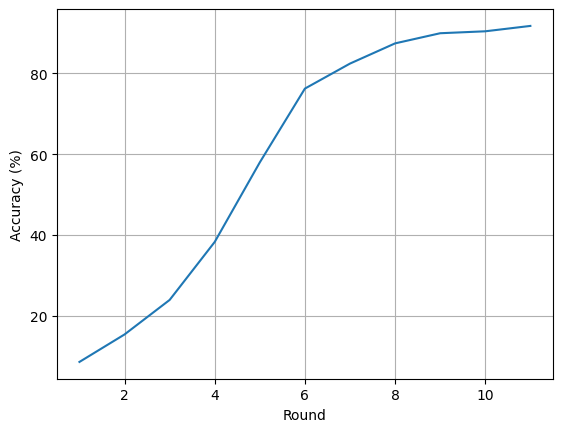

In [21]:
from flwr.simulation import run_simulation



run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)
